Importing all necessary library

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/drive/MyDrive/Capstone/ML/model_training/pest_dataset.zip

Archive:  /content/drive/MyDrive/Capstone/ML/model_training/pest_dataset.zip
replace dataset/aphids/aphids_106.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# Directory containing images of pests
sdir = '/content/drive/MyDrive/Capstone/ML/model_training/dataset'

filepaths = []
labels = []

# Get list of pest classes (sub-directories)
classlist = os.listdir(sdir)

# Iterate over each pest class
for klass in classlist:
    classpath = os.path.join(sdir, klass)

    # Ensure that the item is a directory
    if os.path.isdir(classpath):
        # Get list of image files in the class directory
        flist = os.listdir(classpath)

        # Iterate over each image file in the class directory
        for f in flist:
            # Get the full path of the image file
            fpath = os.path.join(classpath, f)

            # Append the file path to the list of file paths
            filepaths.append(fpath)

            # Append the class label to the list of labels
            labels.append(klass)

# Create a Pandas Series for file paths
Fseries = pd.Series(filepaths, name='filepaths')

# Create a Pandas Series for labels
Lseries = pd.Series(labels, name='labels')

# Concatenate the two Series into a DataFrame
df = pd.concat([Fseries, Lseries], axis=1)

# Print the first few rows of the DataFrame
print(df.head())

# Print the count of images for each pest class
print(df['labels'].value_counts())

                                           filepaths     labels
0  /content/drive/MyDrive/Capstone/ML/model_train...  mealybugs
1  /content/drive/MyDrive/Capstone/ML/model_train...  mealybugs
2  /content/drive/MyDrive/Capstone/ML/model_train...  mealybugs
3  /content/drive/MyDrive/Capstone/ML/model_train...  mealybugs
4  /content/drive/MyDrive/Capstone/ML/model_train...  mealybugs
labels
whiteflies    167
aphids        106
mealybugs      98
Name: count, dtype: int64


In [5]:
#split the ratios 90% for training and 5% for testing
train_split=.9
test_split=.05

#giving the ratio for validation dataset, ensuring bith the test and valdiation sets are both 5%
dummy_split=test_split/(1-train_split)

#split the original df into train (90%) and dummy df
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)

#split the dummy into test and valid df
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)

#print the lenght of dataset
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  333   test_df length:  19   valid_df length:  19


#Prepare ImageDataGenerator

In [6]:
#initializing target size and image format
h_img = 224
w_img = 224
channels = 3
batch_size = 16

In [7]:
img_shape = (h_img, w_img, channels)
img_size = (h_img, w_img)
length = len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps = int(length/test_batch_size)

print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

test batch size:  19   test steps:  1


In [8]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = val_datagen

train_generator = train_datagen.flow_from_dataframe(
   dataframe =  train_df,
    x_col='filepaths',  # Column containing file paths
    y_col='labels',     # Column containing labels
    target_size = img_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = valid_df,
    x_col='filepaths',  # Column containing file paths
    y_col='labels',     # Column containing labels
    target_size = img_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)


test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col='filepaths',  # Column containing file paths
    y_col='labels',     # Column containing labels
    target_size = img_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = batch_size
)



Found 333 validated image filenames belonging to 3 classes.
Found 19 validated image filenames belonging to 3 classes.
Found 19 validated image filenames belonging to 3 classes.


In [9]:
def show_image_samples(gen):
    test_dict=test_generator.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [10]:
show_image_samples(train_generator)

Output hidden; open in https://colab.research.google.com to view.

# Creating The Base Model

In [11]:
base_model = tf.keras.applications.MobileNetV2(
    include_top = False,
    weights = "imagenet",
    input_tensor=Input(shape=(224,224,3))
)

9406464/9406464 [==============================] - 0s 0us/step


In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [13]:
base_model.trainable = False

In [14]:
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,

            # tf.keras.layers.GlobalAveragePooling2D(),
            # tf.keras.layers.Dense(256, activation='relu'),
            # tf.keras.layers.Dropout(0.5),
            # tf.keras.layers.Dense(128, activation='relu'),
            # tf.keras.layers.Dropout(0.5),
            # tf.keras.layers.Dense(3, activation='softmax')


            # best so far
            # tf.keras.layers.GlobalAveragePooling2D(),
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.Dense(64, activation='relu'),
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.Dropout(0.5),
            # tf.keras.layers.Dense(128, activation='relu'),
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.Dropout(0.5),
            # tf.keras.layers.Dense(3, activation='softmax')

            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.BatchNormalization(),


            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(3, activation='softmax')

            # tf.keras.layers.GlobalAveragePooling2D(),
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.Dense(128, activation='relu'),
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.Dropout(0.5),
            # tf.keras.layers.Dense(64, activation='relu'),
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.Dropout(0.5),
            # tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [16]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [17]:
epochs =25

mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history=model.fit(x=train_generator, epochs=epochs, validation_data=val_generator,callbacks=[early_stopping, mc])

Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.7513 - accuracy: 0.3874
Epoch 1: val_accuracy improved from -inf to 0.52632, saving model to best_model.keras
21/21 [==============================] - 111s 5s/step - loss: 1.7513 - accuracy: 0.3874 - val_loss: 0.9354 - val_accuracy: 0.5263
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.4924 - accuracy: 0.4505
Epoch 2: val_accuracy improved from 0.52632 to 0.63158, saving model to best_model.keras
21/21 [==============================] - 48s 2s/step - loss: 1.4924 - accuracy: 0.4505 - val_loss: 0.7857 - val_accuracy: 0.6316
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.2260 - accuracy: 0.5526
Epoch 3: val_accuracy improved from 0.63158 to 0.73684, saving model to best_model.keras
21/21 [==============================] - 42s 2s/step - loss: 1.2260 - accuracy: 0.5526 - val_loss: 0.6989 - val_accuracy: 0.7368
Epoch 4/25
21/21 [==============================] - ETA: 0s - loss

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [20]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

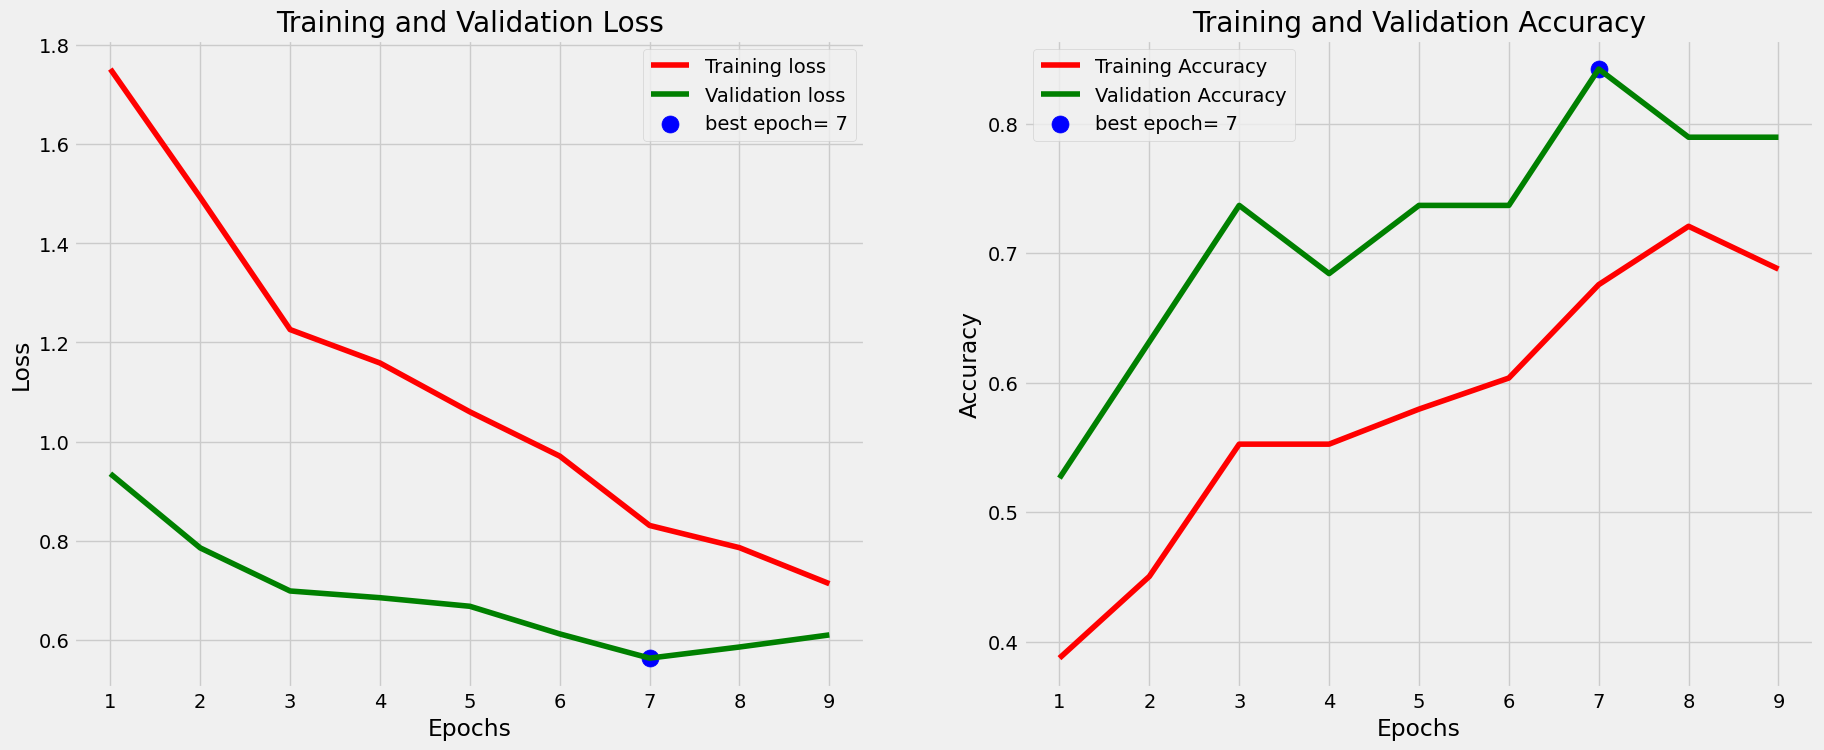

1/1 [==============================] - 2s 2s/step - loss: 0.5471 - accuracy: 0.8750
accuracy on the test set is 87.50 %



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
tr_plot(history,0)
save_dir=r'./'
subject='pest'
acc=model.evaluate( test_generator, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
# save_id=str ( subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
# save_loc=os.path.join(save_dir, save_id)
# model.save(save_loc)
saved_model_path = "./my_model.h5"
model.save(saved_model_path)

In [27]:
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    # Load and preprocess the uploaded image
    img_path = fn
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    # Make predictions
    predictions = model.predict(img_array)

    # Decode the predictions
    class_indices = {0: 'aphids', 1: 'mealybugs', 2: 'whiteflies'}  # Update class indices accordingly
    predicted_class = class_indices[np.argmax(predictions)]

    # Print the predictions
    print(predictions)
    print(f"{fn} is predicted as {predicted_class}")

Saving WhatsApp Image 2024-06-07 at 14.01.06_33973600.jpg to WhatsApp Image 2024-06-07 at 14.01.06_33973600.jpg
1/1 [==============================] - 0s 53ms/step
[[0.22569764 0.01277037 0.76153195]]
WhatsApp Image 2024-06-07 at 14.01.06_33973600.jpg is predicted as whiteflies


In [29]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
     

In [2]:
!tensorflowjs_converter --input_format=keras /content/my_model.h5 ./

2024-06-07 18:13:33.472185: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 18:13:35.093282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
